In [ ]:
!pip uninstall torch torchvision

In [36]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

In [37]:
from src.helper_functions import plot_random_image_and_label, print_model_parameter_breakdown

In [38]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "epochs": 10,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

TRANSFORM_CONFIG = {
    "image_size": (224, 224),  # (height, width)
    "normalize_mean": [0.485, 0.456, 0.406],  # ImageNet mean
    "normalize_std": [0.229, 0.224, 0.225],   # ImageNet std
    "random_horizontal_flip_prob": 0.5,
    "random_rotation_degrees": 15,
}

In [39]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Creating a Custom Dataset For Your Files:

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

In [40]:
class WasteClassificationDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        '''
            This initializes the dataset
            Args:
                root_dir (str): Directly with subfolders
                transform (callable): For transforming images like Augmentation

            We pass in data/train or data/test
        '''

        self.root_dir = root_dir # To know where to find images
        self.transform = transform

        self.classes = []
        all_items = os.listdir(root_dir) # in our case, its paper, metal, glass, plastic.
        
        # getting all directories in /train for
        for item in all_items:
            item_path = os.path.join(root_dir, item)

            if os.path.isdir(item_path):
                self.classes.append(item)

        self.classes = sorted(self.classes) #folder names as classes

        self.class_to_idx = {}
        for idx, class_name in enumerate(self.classes):
            self.class_to_idx[class_name] = idx
        # e.g. {'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3} -- Alphabetically

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            all_files = os.listdir(class_dir)
            for img_name in all_files:
                if img_name.endswith(".jpg"):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        '''
            return number of samples in the dataset
        '''
        return len(self.samples)

    def __getitem__(self, idx):
        '''
            Return one sample at given index
        '''
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        # the above opens image file and converts to RGB

        if self.transform:
            image = self.transform(image)
            #we transform here so we can apply different transformations
        
        return image, label
    
    def plot_stuff(self, num_samples_per_class=4, show_transformed=True):
        """
        Plot sample images from each class in a grid
        
        Args:
            num_samples_per_class: Number of images to show per class
            show_transformed: If True, shows transformed images (as used in training)
                             If False, shows original images
        """
        num_classes = len(self.classes)
        fig, axes = plt.subplots(num_classes, num_samples_per_class, 
                                figsize=(num_samples_per_class * 2, num_classes * 2))
        
        # If only one class, make axes 2D
        if num_classes == 1:
            axes = axes.reshape(1, -1)
        
        # Use constants from TRANSFORM_CONFIG
        mean = np.array(TRANSFORM_CONFIG["normalize_mean"])
        std = np.array(TRANSFORM_CONFIG["normalize_std"])
        
        for class_idx, class_name in enumerate(self.classes):
            # Get samples for this class
            class_samples = [s for s in self.samples if s[1] == class_idx]
            
            # Randomly select samples
            if len(class_samples) > num_samples_per_class:
                selected = np.random.choice(len(class_samples), num_samples_per_class, replace=False)
                selected_samples = [class_samples[i] for i in selected]
            else:
                selected_samples = class_samples
                # If we have fewer samples than requested, pad with repeats
                while len(selected_samples) < num_samples_per_class:
                    selected_samples.extend(class_samples[:num_samples_per_class - len(selected_samples)])
                    selected_samples = selected_samples[:num_samples_per_class]
            
            # Plot each sample
            for col, (img_path, label) in enumerate(selected_samples):
                if show_transformed:
                    # Get transformed image (as it would be used in training)
                    sample_idx = self.samples.index((img_path, label))
                    image, _ = self.__getitem__(sample_idx)
                    image_np = image.numpy().transpose((1, 2, 0))
                    # Denormalize
                    image_np = image_np * std + mean
                    image_np = np.clip(image_np, 0, 1)
                else:
                    # Show original image
                    image = Image.open(img_path).convert("RGB")
                    image_np = np.array(image) / 255.0
                
                ax = axes[class_idx, col] if num_classes > 1 else axes[col]
                ax.imshow(image_np)
                ax.set_title(f'{class_name}\n(y={class_idx})', fontsize=10)
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

In [41]:
train_transforms = transforms.Compose([
    transforms.Resize(TRANSFORM_CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=TRANSFORM_CONFIG["normalize_mean"], 
        std=TRANSFORM_CONFIG["normalize_std"]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize(TRANSFORM_CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=TRANSFORM_CONFIG["normalize_mean"], 
        std=TRANSFORM_CONFIG["normalize_std"]
    )
])

In [42]:
train_dataset = WasteClassificationDataset("./data/train", transform=train_transforms)
test_dataset = WasteClassificationDataset("./data/test", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)



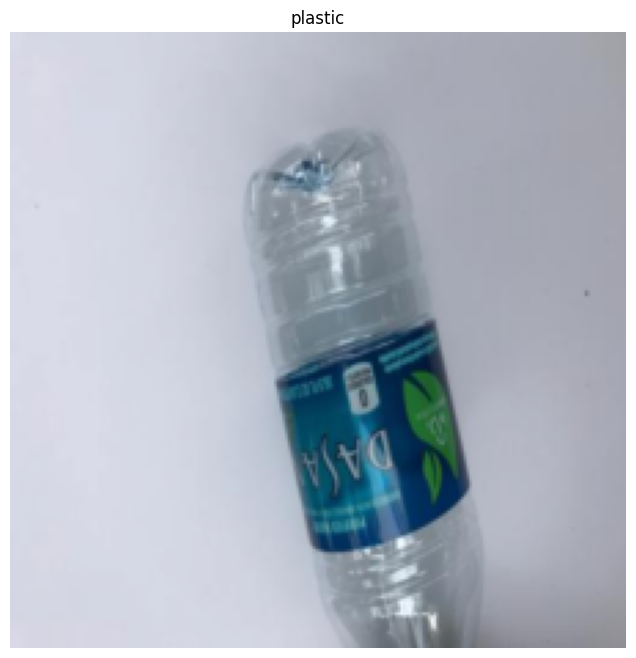

Index: 1394
Label (integer): 3
Class name: plastic
Image tensor shape: (224, 224, 3)


In [43]:
plot_random_image_and_label(
    train_dataset, 
    train_dataset.classes,
    mean=TRANSFORM_CONFIG["normalize_mean"],
    std=TRANSFORM_CONFIG["normalize_std"]
)

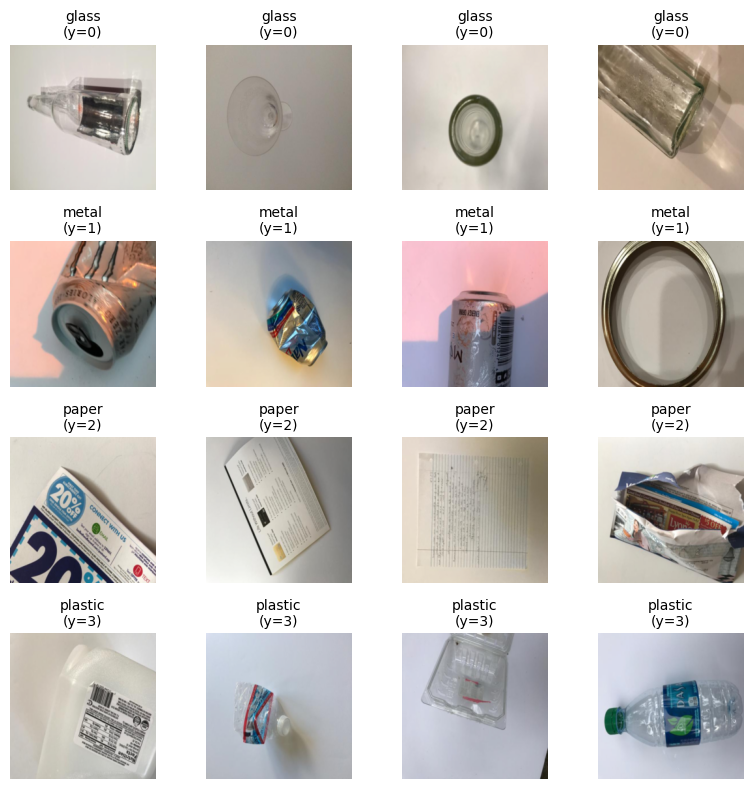

In [44]:
# Plot sample images from each class using the plot_stuff method
train_dataset.plot_stuff(num_samples_per_class=4, show_transformed=True)


# Introduction
- summarize your work, clearly stating the project's objectives. 

<div style = "color:blue">
    We are given a Waste Dataset, divided into training and test set with each having for class labels (glass, metal, paper, and plastic) and our goal is to develop a Deep Neural Network to classify images correctly into one of these types. 
    For this project, I will be using PyTorch for my Implementation
</div>

# Deep Learning Architecture:

Explain your Deep Learning Architecture: What kind of Deep Learning architecture did you use in your project, and why? Number of layers? Number of hidden units? etc.


<div style = "color:purple">
https://medium.com/@sahin.samia/mastering-the-basics-of-torch-nn-a-comprehensive-guide-to-pytorchs-neural-network-module-9f2d704e8c7f <br>

torch.nn = It provides a rich collection of tools to define, manage, and manipulate deep learning models efficiently. With torch.nn, you can construct everything from simple feedforward networks to highly complex architectures like convolutional and recurrent neural networks. <br>

Every model in PyTorch is essentially a subclass of nn.Module, making it the essential blueprint for neural network design. It provides:

Initialization (__init__): Define the layers and components of your network. <br>
Forward Pass (forward): Specify how data flows through the layers of your network. <br>
Parameter Management: Automatically tracks and optimizes model parameters.<br>

<br>
- Common Layers in nn <br>

1. nn.Linear: Fully Connected Layer <br>
Purpose: Applies a linear transformation: y = xW^T + b <br>
Common Use: Used in feedforward networks for dense connections between layers.<br>

2. nn.ReLU: Activation Function <br>
Purpose: Applies the ReLU function: ReLU(x)=max⁡(0,x) <br>
Common Use: Adds non-linearity after linear <br>

3. nn.Dropout: Dropout Regularization <br>
Purpose: Randomly sets a fraction of input neurons to zero during training to prevent overfitting. <br>
Common Use: Used after fully connected layers or in deeper architectures. <br>
</div>

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes: list[int], num_classes: int, dropout_rates: list[float] = None):
        super(NeuralNetwork, self).__init__()

        # Build complete list of layer sizes from input to output
        # [input_size] creates a list with one element: [150528]
        # + hidden_sizes adds hidden layers: [150528, 512, 256, 128]
        # + [num_classes] adds output layer: [150528, 512, 256, 128, 4]
        layer_sizes = [input_size] + hidden_sizes + [num_classes]

        #layer_sizes[0]=150528, layer_sizes[1]=512 creates Linear(150528, 512)
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

        self.dropouts = nn.ModuleList()

        # Why different rates? Early layers learn low-level features (need more regularization)
        # Later layers learn high-level features (need less regularization)
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)

        for rate in dropout_rates:
            if rate > 0:
                self.dropouts.append(nn.Dropout(rate))
            else:
                self.dropouts.append(nn.Identity())

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the image

        # process all layers except last because that will be processed separately because its the output layer
        for i in range(len(self.layers)-1):

            # linear transformation: x = W.T * x + b
            x = self.layers[i](x) # # This is equivalent to: x = x @ W.T + b (wow)
            x = F.relu(x)
            x = self.dropouts[i](x)

        # Last Layer
        x = self.layers[-1](x)
        return x    

In [46]:
image, label = train_dataset[0]
image.shape # need to flatten the image



torch.Size([3, 224, 224])

In [47]:
# instance of the model
model_instance_one_no_dropout = NeuralNetwork(
    input_size=224*224*3,           
    hidden_sizes=[512, 256, 128], 
    num_classes=4, 
)

In [48]:
print_model_parameter_breakdown(model_instance_one_no_dropout)


                     DETAILED PARAMETER CALCULATION BREAKDOWN: Model                      

──────────────────────────────────────────────────────────────────────────────────────────
LAYER 1: Linear(150,528 → 512)
──────────────────────────────────────────────────────────────────────────────────────────
  Input size:  150,528
  Output size: 512

  WEIGHTS:
    • Shape: (512, 150,528)
    • Calculation: 150,528 × 512 = 77,070,336
    • Actual count: 77,070,336 ✓

  BIAS:
    • Shape: (512,)
    • Calculation: 512 × 1 = 512
    • Actual count: 512 ✓

  LAYER TOTAL: 77,070,336 + 512 = 77,070,848
  Cumulative: 77,070,848

──────────────────────────────────────────────────────────────────────────────────────────
LAYER 2: Linear(512 → 256)
──────────────────────────────────────────────────────────────────────────────────────────
  Input size:  512
  Output size: 256

  WEIGHTS:
    • Shape: (256, 512)
    • Calculation: 512 × 256 = 131,072
    • Actual count: 131,072 ✓

  BIAS:
    • Shape:

In [49]:
model_instance_one_no_dropout = model_instance_one_no_dropout.to(device)

# Loss function:

Which loss function did you select to use and why?


Plot the change in your loss function (both training loss and test loss) vs epoch. Your code shall generate the “Change of Training and Test losses vs Epoch’ graph

Discuss these loss curves

<div style = "color:purple">
    Used to quantify the difference between predicted and actual. <br><br>
    Common Activation Functions <br>
    1. nn.MSELoss: Mean Squared Error Loss<br>
    Purpose: Measures the average squared difference between the predicted values and the actual target values. <br>
    Common Use: Used in regression tasks where the goal is to predict continuous values. <br><br>
    2. nn.CrossEntropyLoss: Cross-Entropy Loss <br>
    Purpose: Combines nn.LogSoftmax and nn.NLLLoss to calculate the cross-entropy between predicted probabilities and true class labels. <br>
    Common Use: Used in multi-class classification tasks. <br><br>
    3. nn.BCELoss: Binary Cross-Entropy for binary classification problems. <br><br>
    4. nn.BCEWithLogitsLoss: Combines a Sigmoid activation with Binary Cross-Entropy, more numerically stable than using nn.BCELoss with a separate Sigmoid.<br><br>
    5. nn.HingeEmbeddingLoss: Useful for tasks like similarity learning or when using SVM-like objectives.<br><br>
    6. nn.SmoothL1Loss: Combines MSE and L1 losses to handle outliers more gracefully.<br><br>
</div>


In [50]:
criterion = nn.CrossEntropyLoss()

<div style = "color:darkblue">
    Optimizers and torch.optim Integration <br><br>
    Models built with torch.nn automatically track their trainable parameters (e.g., weights and biases). <br>
    These parameters are passed to an optimizer from torch.optim to compute and apply parameter updates. <br><br>
    torch.nn defines the structure and forward computation of the model. <br>
    torch.optim takes care of adjusting the model's parameters during training based on the gradients computed by backpropagation. <br><br>
    torch.nn computes the forward pass and loss.<br>
    Gradients are computed via loss.backward().<br>
    torch.optim updates parameters using optimizer.step().<br><br>
    1. Stochastic Gradient Descent (SGD)<br>
        Description: Updates parameters by moving them in the direction of the negative gradient of the loss function.<br>
        Configuration:<br>
        lr (learning rate): Controls the step size for updates.<br>
        momentum: Adds inertia to the updates, helping to overcome small local minima.<br><br>
    2.  Adam Optimizer <br>
        Description: Combines the benefits of SGD with momentum and adaptive learning rates. <br>
        Configuration: <br>
        lr: Learning rate.<br>
        betas: Coefficients for computing moving averages of gradient and its square (default: (0.9, 0.999)).<br>
        eps: Small value to prevent division by zero.<br><br>
    3. RMSprop<br>
        Description: Similar to Adam but uses only squared gradients to adjust learning rates.<br>
        Common Use: Suitable for recurrent neural networks.<br><br>
    4. Adagrad: Adjusts learning rates for individual parameters based on their updates.<br><br>
    5. AdamW: A variant of Adam with decoupled weight decay for better generalization.<br><br>
</div>

In [51]:
optimizer = torch.optim.Adam(
    model_instance_one_no_dropout.parameters(),              
    lr=config["learning_rate"]       
)

In [52]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch with multiclass metrics.
    
    Returns:
        dict: {'loss': avg_loss, 'accuracy': accuracy, 
               'precision_macro': precision, 'recall_macro': recall, 
               'f1_macro': f1, 'precision_weighted': precision_w, 
               'recall_weighted': recall_w, 'f1_weighted': f1_w,
               'y_true': true_labels, 'y_pred': predicted_labels}
    """
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Collect predictions and labels
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return {
        'loss': running_loss / len(train_loader),
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'y_true': y_true,
        'y_pred': y_pred
    }

In [53]:
def evaluate(model, data_loader, criterion, device):
    """
    Evaluate the model on a dataset with multiclass metrics.
    
    Returns:
        dict: Same structure as train_epoch
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return {
        'loss': running_loss / len(data_loader),
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'y_true': y_true,
        'y_pred': y_pred
    }

In [54]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, verbose=True):
    """
    Train model with separate train and validation phases.
    
    Returns:
        dict: Training history with metrics per epoch
    """
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'train_precision_macro': [],
        'train_recall_macro': [],
        'train_f1_macro': [],
        'train_precision_weighted': [],
        'train_recall_weighted': [],
        'train_f1_weighted': [],
    }
    
    for epoch in range(num_epochs):
        # Training
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_losses'].append(train_metrics['loss'])
        history['train_accuracies'].append(train_metrics['accuracy'])
        history['train_precision_macro'].append(train_metrics['precision_macro'])
        history['train_recall_macro'].append(train_metrics['recall_macro'])
        history['train_f1_macro'].append(train_metrics['f1_macro'])
        history['train_precision_weighted'].append(train_metrics['precision_weighted'])
        history['train_recall_weighted'].append(train_metrics['recall_weighted'])
        history['train_f1_weighted'].append(train_metrics['f1_weighted'])
        
        # Print progress
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, F1: {train_metrics["f1_macro"]:.4f}')
            print('-' * 50)
    
    return history

In [55]:
model_instance_one_no_dropout = train_model(
    model=model_instance_one_no_dropout,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=config["epochs"],
    verbose=True
)

TypeError: train_model() got an unexpected keyword argument 'test_loader'. Did you mean 'train_loader'?

In [ ]:
history_model_one_no_dropout = train_model(
    model=model_instance_one_no_dropout,
    train_loader=train_loader,
    val_loader=None,  # or just omit this parameter
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=config["epochs"],
    verbose=True
)

# Hyperparameters

The number of layers


Number of nodes at each layer


Learning rate


“Mini batch” size
- What is the mini-batch size you used in your code?


- Why did you select this value?



Activation functions
- What is the activation function(s) used in your code?



- Why did you select them to use?



Optimization function
- Which optimization function did you use? Why?



- What are the optimization parameters used?


Regularization function 
- Did you use any regularization function?




- Why used/ not used?




- If used, what are the regularization parameters?




Epochs
- What is the number of epochs used?




- Why did you select this value?





# Explanation of the developed code

Explain the essential functions/classes you developed in your code.

Explain how to run your code if you are using the “command prompt” or any environment other than VS Code and Jupyter. 

<div style = "color:blue">
- WasteClassificationDataset Class
This class was was created by inheriting the Dataset Class provided by PyTorch. Three required methods were created which include _init__, __len__ and __getitem__ which are required by PyTorch Dataset interface.

The images were organized by class folders(paper, metal, glass, plastic), which made it easier to create class labels for the dataset.

This could've been done using base Python as well, but PyTorch provides additional helpful tooks like Automatic Differentiation for back propogation, optimizers etc which is why we need PyTorch to convert the dataset into tensors.

<div>


# Hyperparameter Optimization 

Optimize your “learning rate” and “number of layers
What is the effect of “optimization” on “learning rate” and “number of layers”?  (indicate starting values and the optimized values)





How did you optimize your hyperparameters?






What are the optimization results (show the numerical values and state how you improved them)




# Discuss the Performance of Your Model:

- Confusion matrix 

What is the metric selected to evaluate your model?


What is the best metric value obtained? 


What kind of error(s) do you have in your model? Discuss your errors, state what they mean. 


Due to the errors stated above, what shall be done to improve your model’s performance?


Which techniques have you applied to improve your model’s performance? 


Do you have overfitting or underfitting/overfitting in your model? Which processes did you apply to prevent underfitting/overfitting? 



# Error analysis and misclassified examples

Please discuss the error analysis you performed in your project.


# Deep Learning Strategies

What are the Deep Learning Strategies you performed in this project? 




If they exist, why did you select these strategies to apply? 


# Discussion and Conclusion

Discuss your results and draw conclusions from your work. State what you learned in this project. 
